In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2025-08-07 08:01:42.242309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754553702.439614      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754553702.492301      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Dataset Exploration

With mask images: 3725
Without mask images: 3828


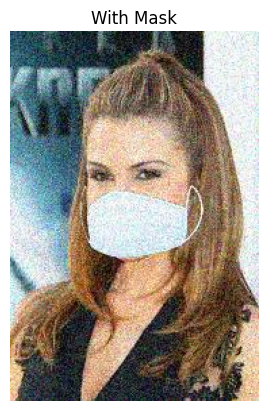

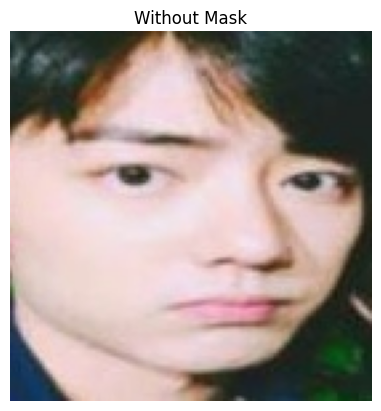

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Dataset path in Kaggle kernel
dataset_dir = "/kaggle/input/face-mask-dataset/data"

with_mask_dir = os.path.join(dataset_dir, "with_mask")
without_mask_dir = os.path.join(dataset_dir, "without_mask")

print("With mask images:", len(os.listdir(with_mask_dir)))
print("Without mask images:", len(os.listdir(without_mask_dir)))

# Show one sample from each category
def show_image(img_path, title):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(os.path.join(with_mask_dir, os.listdir(with_mask_dir)[5]), "With Mask")
show_image(os.path.join(without_mask_dir, os.listdir(without_mask_dir)[5]), "Without Mask")


In [3]:
for i in range(10):
    img = cv2.imread(os.path.join(with_mask_dir, os.listdir(with_mask_dir)[i]))
    print("With Mask Image shape :", img.shape)
    img = cv2.imread(os.path.join(without_mask_dir, os.listdir(without_mask_dir)[i]))
    print("Without Mask Image shape:", img.shape)



With Mask Image shape : (800, 800, 3)
Without Mask Image shape: (135, 148, 3)
With Mask Image shape : (1000, 800, 3)
Without Mask Image shape: (225, 225, 3)
With Mask Image shape : (100, 69, 3)
Without Mask Image shape: (428, 320, 3)
With Mask Image shape : (211, 239, 3)
Without Mask Image shape: (221, 228, 3)
With Mask Image shape : (517, 335, 3)
Without Mask Image shape: (147, 160, 3)
With Mask Image shape : (274, 184, 3)
Without Mask Image shape: (139, 136, 3)
With Mask Image shape : (393, 278, 3)
Without Mask Image shape: (111, 124, 3)
With Mask Image shape : (416, 276, 3)
Without Mask Image shape: (154, 327, 3)
With Mask Image shape : (578, 1024, 3)
Without Mask Image shape: (139, 159, 3)
With Mask Image shape : (649, 975, 3)
Without Mask Image shape: (125, 100, 3)


#### It is clearly seen from the image shapes that every shape has different dimensions and it is not acceptable by the Convolution Neural Network.<br>    
* **I will resize all images to one unique size "128 x 128"** <br>
* **Normalize Pixel values from 0-255 to 0-1**


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

img_size = 128
data = []
labels = []

# Function to load, resize, normalize images
def preprocess_image(path, label):
    img = cv2.imread(path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # normalize to 0–1
    data.append(img)
    labels.append(label)

# Load with_mask images
for img_name in os.listdir(with_mask_dir):
    preprocess_image(os.path.join(with_mask_dir, img_name), 1)

# Load without_mask images
for img_name in os.listdir(without_mask_dir):
    preprocess_image(os.path.join(without_mask_dir, img_name), 0)

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)


Data shape: (7553, 128, 128, 3)
Labels shape: (7553,)


# **Train Test Split**

In [5]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (6042, 128, 128, 3)
Test set: (1511, 128, 128, 3)


## 🔁 First Attempt (No Augmentation)
- Model trained on raw dataset
- Signs of overfitting after 10 epochs
- Validation accuracy plateaued at ~94%


# **Model Building**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Try commenting this later to test overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754553770.977073      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10


I0000 00:00:1754553778.062168      60 service.cc:148] XLA service 0x79b00c00ad90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754553778.062857      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754553778.366192      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 18/189 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5285 - loss: 1.2248

I0000 00:00:1754553781.008857      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7302 - loss: 0.6293 - val_accuracy: 0.8915 - val_loss: 0.2626
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8937 - loss: 0.2711 - val_accuracy: 0.8882 - val_loss: 0.2801
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9117 - loss: 0.2295 - val_accuracy: 0.9239 - val_loss: 0.1986
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9414 - loss: 0.1512 - val_accuracy: 0.9279 - val_loss: 0.1914
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9619 - loss: 0.1098 - val_accuracy: 0.9358 - val_loss: 0.1847
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9632 - loss: 0.0997 - val_accuracy: 0.9246 - val_loss: 0.2009
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9709 - loss: 0.0707 - val_accuracy: 0.9345 - val_loss: 0.1993
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9840 - loss: 0.0472 - val_accuracy: 0.93

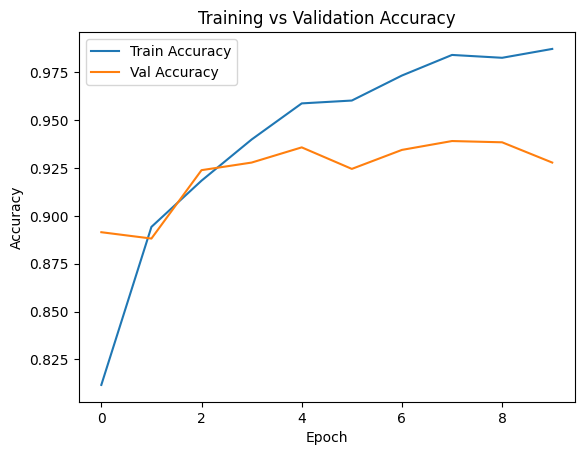

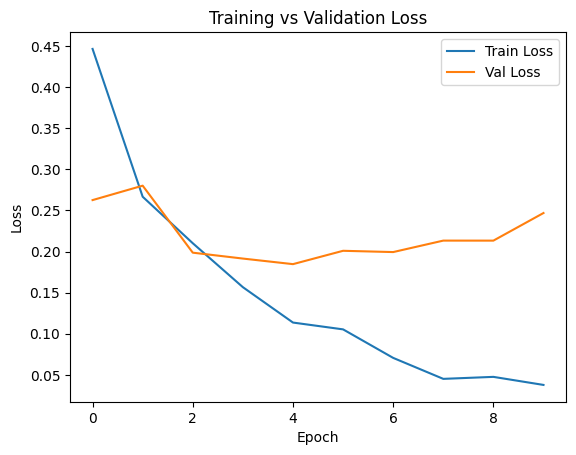

In [8]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 🔁 Second Attempt (With Image Augmentation)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# For test/validation, we only rescale (no augmentation)
test_datagen = ImageDataGenerator()

# Create generators from numpy arrays
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)


In [10]:
history_aug = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.8784 - loss: 0.3107 - val_accuracy: 0.9404 - val_loss: 0.1582
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.9068 - loss: 0.2505 - val_accuracy: 0.9431 - val_loss: 0.1493
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9146 - loss: 0.2133 - val_accuracy: 0.9451 - val_loss: 0.1475
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9101 - loss: 0.2085 - val_accuracy: 0.9418 - val_loss: 0.1479
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9227 - loss: 0.1869 - val_accuracy: 0.9411 - val_loss: 0.1579
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9236 - loss: 0.1932 - val_accuracy: 0.9530 - val_loss: 0.1339
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9284 - loss: 0.1758 - val_accuracy: 0.9219 - val_loss: 0.1779
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9297 - loss: 0

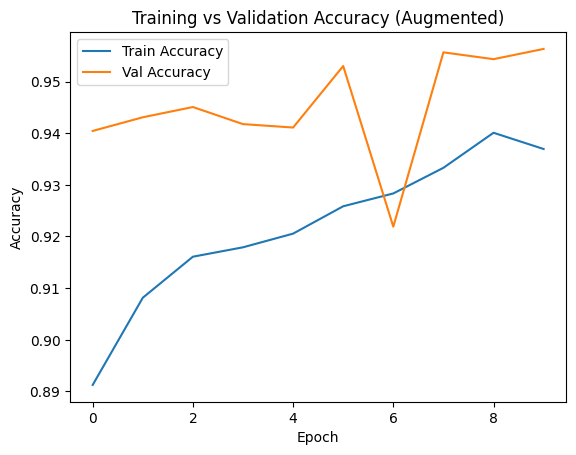

In [11]:
plt.plot(history_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy (Augmented)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
# Save trained model
model.save("face_mask_model.h5")
